# Изучение свойств опционов. Часть 1.
> выполнил Литвинов А. А., гр. МФИН211

## 1. Загрузка библиотек

In [11]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime, timedelta
from __future__ import division
import networkx as nx  # библиотеке визуализации графов
import matplotlib.pyplot as plt  # графическая библиотека
%matplotlib inline

## 2. Загрузка и подготовка данных

### Данные по опционам

In [12]:
cboe_options = pd.read_csv("https://github.com/qununc/financials_repo/raw/main/AppliedModels/ap_data/UnderlyingOptionsEODCalcs_2019-02-04.csv", parse_dates=True)

In [13]:
cboe_options.columns

Index(['underlying_symbol', 'quote_date', 'root', 'expiration', 'strike',
       'option_type', 'open', 'high', 'low', 'close', 'trade_volume',
       'bid_size_1545', 'bid_1545', 'ask_size_1545', 'ask_1545',
       'underlying_bid_1545', 'underlying_ask_1545',
       'implied_underlying_price_1545', 'active_underlying_price_1545',
       'implied_volatility_1545', 'delta_1545', 'gamma_1545', 'theta_1545',
       'vega_1545', 'rho_1545', 'bid_size_eod', 'bid_eod', 'ask_size_eod',
       'ask_eod', 'underlying_bid_eod', 'underlying_ask_eod', 'vwap',
       'open_interest', 'delivery_code'],
      dtype='object')

In [14]:
cboe_options.head()

,underlying_symbol,quote_date,root,expiration,strike,option_type,open,high,low,close,...,rho_1545,bid_size_eod,bid_eod,ask_size_eod,ask_eod,underlying_bid_eod,underlying_ask_eod,vwap,open_interest,delivery_code
0,AAPL,2019-02-04,AAPL,2019-02-08,100.0,C,0.0,0.0,0.0,0.0,...,0.9958,15,71.05,42,71.40,171.26,171.27,0.0,12,NaN
1,AAPL,2019-02-04,AAPL,2019-02-08,100.0,P,0.0,0.0,0.0,0.0,...,-0.0012,0,0.00,102,0.01,171.26,171.27,0.0,464,NaN
2,AAPL,2019-02-04,AAPL,2019-02-08,105.0,C,0.0,0.0,0.0,0.0,...,1.0550,15,66.05,138,66.50,171.26,171.27,0.0,10,NaN
3,AAPL,2019-02-04,AAPL,2019-02-08,105.0,P,0.0,0.0,0.0,0.0,...,-0.0013,0,0.00,92,0.01,171.26,171.27,0.0,115,NaN
4,AAPL,2019-02-04,AAPL,2019-02-08,110.0,C,0.0,0.0,0.0,0.0,...,1.1147,10,61.10,131,61.50,171.26,171.27,0.0,4,NaN


In [15]:
cboe_options.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3260 entries, 0 to 3259
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   underlying_symbol              3260 non-null   object 
 1   quote_date                     3260 non-null   object 
 2   root                           3260 non-null   object 
 3   expiration                     3260 non-null   object 
 4   strike                         3260 non-null   float64
 5   option_type                    3260 non-null   object 
 6   open                           3260 non-null   float64
 7   high                           3260 non-null   float64
 8   low                            3260 non-null   float64
 9   close                          3260 non-null   float64
 10  trade_volume                   3260 non-null   int64  
 11  bid_size_1545                  3260 non-null   int64  
 12  bid_1545                       3260 non-null   f

In [16]:
cboe_options["expiration"] = cboe_options["expiration"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d")
)
### преобразование поля даты в необходимый формат

In [17]:
cboe_options["quote_date"] = cboe_options["quote_date"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d")
)

### Базовый актив

In [18]:
import yfinance as yf

# Input Start and End Date
start = datetime(2013, 12, 9)
end = datetime(2022, 9, 2)

# xom = yf.download('XOM', interval='1d', start=start, end=end, progress=False, show_errors=False)\
#     .dropna(axis=0)
# xom.to_csv("ap_data\\XOM.csv")

In [19]:
xom = pd.read_csv("https://github.com/qununc/financials_repo/raw/main/AppliedModels/ap_data/XOM.csv")

In [20]:
xom.iloc[[0, -1], :]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-09 00:00:00-05:00,95.949997,96.25,95.599998,95.839996,64.983673,15516700
2198,2022-09-01 00:00:00-04:00,94.419998,95.07,92.290001,93.870003,93.870003,16423000


In [21]:
type(xom.Date[0])

str

In [22]:
xom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2199 entries, 0 to 2198
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2199 non-null   object 
 1   Open       2199 non-null   float64
 2   High       2199 non-null   float64
 3   Low        2199 non-null   float64
 4   Close      2199 non-null   float64
 5   Adj Close  2199 non-null   float64
 6   Volume     2199 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 120.4+ KB


In [23]:
xom["Date"] = xom["Date"].apply(lambda x: x.split()[0])
xom["Date"] = xom["Date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

In [24]:
xom.sample(3)

,Date,Open,High,Low,Close,Adj Close,Volume
1862,2021-05-04,59.000000,59.500000,58.509998,59.189999,54.983448,23522200
1728,2020-10-20,33.660000,33.930000,33.330002,33.700001,30.057064,23040600
1209,2018-09-27,86.089996,86.379997,85.589996,85.769997,68.539207,7895400


## 3. Выбор опционов для анализа 

In [25]:
date = "2019-02-04"  # дата расчетов
quote_date = datetime.strptime(date, "%Y-%m-%d")  # дата расчетов
quote_date

datetime.datetime(2019, 2, 4, 0, 0)

In [26]:
expiration_date = "2019-02-15"  # дата экспирации
expiration_date = datetime.strptime(expiration_date, "%Y-%m-%d")
expiration_date

datetime.datetime(2019, 2, 15, 0, 0)

In [27]:
# цена спот в дату расчета
S_0 = float(xom[xom.Date == quote_date]["Close"])
print(S_0)

74.81999969482422


In [28]:
# количество дней до экспирации
days = (expiration_date - quote_date).days
T = days / 250
T

0.044

In [29]:
div_y = 0.0172  # непрерывная дивидендная ставка (можно взять с сайта yahoo)

In [30]:
# полный набор страйков
strikes = np.array(
    cboe_options[
        (cboe_options.quote_date == quote_date)
        & (cboe_options.underlying_symbol == "XOM")
        & (cboe_options.expiration == expiration_date)
    ]["strike"].unique()
)

In [31]:
strikes

array([ 40. ,  45. ,  47.5,  50. ,  55. ,  60. ,  61. ,  62. ,  62.5,
        63. ,  64. ,  65. ,  65.5,  66. ,  66.5,  67. ,  67.5,  68. ,
        68.5,  69. ,  69.5,  70. ,  70.5,  71. ,  71.5,  72. ,  72.5,
        73. ,  73.5,  74. ,  74.5,  75. ,  75.5,  76. ,  76.5,  77. ,
        77.5,  78. ,  78.5,  79. ,  80. ,  81. ,  82. ,  82.5,  83. ,
        84. ,  85. ,  87.5,  90. ,  95. , 100. , 105. , 110. , 115. ])

In [32]:
# страйк ATM
index_ATM = np.argmin(np.abs(strikes - S_0))
index_ATM

31

In [33]:
# вспомогательный индекс для построения списка страйков
strike_range_index = 5

In [34]:
# максимальный и минимальный индексы для  списка страйков
index_min = max(0, index_ATM - strike_range_index)
index_max = min(len(strikes) - 1, index_ATM + strike_range_index)
print(index_min, index_max)

26 36


In [35]:
# создание списка страйков
strikes_range = strikes[index_min:index_max]
max(strikes_range)

77.0

In [36]:
# массив данных по выбранным опционам колл
cboe_XOM_call = cboe_options[
    (cboe_options.quote_date == quote_date)
    & (cboe_options.underlying_symbol == "XOM")
    & (cboe_options.option_type == "C")
    & (cboe_options.expiration == expiration_date)
    & (cboe_options.strike <= max(strikes_range))
    & (cboe_options.strike >= min(strikes_range))
][
    [
        "strike",
        "high",
        "low",
        "close",
        "delta_1545",
        "gamma_1545",
        "vega_1545",
        "implied_volatility_1545",
    ]
]

In [37]:
cboe_XOM_call

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545
2640,72.5,2.91,2.10,2.36,0.7241,0.1100,0.0426,0.2294
2642,73.0,2.15,1.80,1.80,0.6797,0.1305,0.0458,0.2076
2644,73.5,1.71,1.28,1.44,0.6165,0.1484,0.0490,0.1955
2646,74.0,1.58,0.97,1.10,0.5410,0.1630,0.0511,0.1856
2648,74.5,1.53,0.68,0.81,0.4557,0.1724,0.0512,0.1756
2650,75.0,1.27,0.48,0.58,0.3664,0.1698,0.0487,0.1696
2652,75.5,0.71,0.32,0.36,0.2807,0.1562,0.0436,0.1653
2654,76.0,0.65,0.22,0.24,0.2054,0.1340,0.0369,0.1628
2656,76.5,0.60,0.15,0.15,0.1453,0.1079,0.0296,0.1623
2658,77.0,0.17,0.10,0.10,0.0992,0.0824,0.0226,0.1624


In [38]:
# массив данных по выбранным опционам пут
cboe_XOM_put = cboe_options[
    (cboe_options.quote_date == quote_date)
    & (cboe_options.underlying_symbol == "XOM")
    & (cboe_options.option_type == "P")
    & (cboe_options.expiration == expiration_date)
    & (cboe_options.strike <= max(strikes_range))
    & (cboe_options.strike >= min(strikes_range))
][
    [
        "strike",
        "high",
        "low",
        "close",
        "delta_1545",
        "gamma_1545",
        "vega_1545",
        "implied_volatility_1545",
    ]
]

In [39]:
cboe_XOM_put

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545
2641,72.5,0.56,0.27,0.40,-0.2478,0.1171,0.0410,0.2069
2643,73.0,0.66,0.53,0.53,-0.3088,0.1327,0.0456,0.2033
2645,73.5,0.91,0.72,0.72,-0.3785,0.1445,0.0492,0.2013
2647,74.0,1.15,0.88,0.90,-0.4532,0.1512,0.0511,0.2001
2649,74.5,1.39,1.16,1.19,-0.5295,0.1508,0.0513,0.2012
2651,75.0,1.75,1.36,1.45,-0.6029,0.1446,0.0496,0.2027
2653,75.5,2.11,1.49,1.90,-0.6685,0.1325,0.0465,0.2075
2655,76.0,2.40,2.18,2.29,-0.7258,0.1184,0.0425,0.2124
2657,76.5,0.00,0.00,0.00,-0.7664,0.1021,0.0389,0.2254
2659,77.0,3.30,2.80,3.30,-0.7958,0.0878,0.0359,0.2416


## 4. Модель CRR

### Алгоритм  модели биномиального дерева CRR и соответствующие формулы приведены в лекционных материалах. Программная реализация модели осуществляется с помощью создания класса. Класс объединяет методы (функции) и переменные или, иначе, реализует механизм инкапсуляции, являющийся важнейшим элементом объектно-ориентированного программирования.

In [40]:
class CRR:
    def __init__(
        self, S_0, K, r, T, N, sigma, div=0, t=0, is_call=True, is_european=True
    ):
        self._S_0 = S_0
        self._K = K
        self._r = r
        self._div = div
        self._T = T
        self._N = N
        self._sigma = sigma
        self._t = t
        self._is_call = is_call
        self._is_european = is_european

    def __set_up__(self):
        self._dt = T / N
        self._df = np.exp(-(self._r - self._div) * self._dt)
        self._u = np.exp(self._sigma * np.sqrt(self._dt))
        self._d = 1 / self._u
        self._p = (np.exp((self._r - self._div) * self._dt) - self._d) / (
            self._u - self._d
        )
        self._q = 1 - self._p

    def __path_gen__(self):
        self._S = [np.array([self._S_0])]
        for i in range(self._N):
            prev = self._S[-1]
            st = np.concatenate((prev * self._u, [prev[-1] * self._d]))
            self._S.append(st)

    def __initialize_payoffs__(self):
        final_state = self._S[N]
        return (
            np.maximum(0, (final_state - self._K))
            if self._is_call
            else np.maximum(0, (self._K - final_state))
        )

    def __check_early_ex__(self, i, payoffs):
        early_payoffs = (
            (self._S[i] - self._K) if self._is_call else (self._K - self._S[i])
        )
        return np.maximum(early_payoffs, payoffs)

    def __traverse_tree__(self, payoffs):
        for i in reversed(range(self._N)):
            payoffs = (payoffs[:-1] * self._p + payoffs[1:] * self._q) * self._df
            # print(payoffs)
            if not self._is_european:
                payoffs = self.__check_early_ex__(i, payoffs)
        return payoffs

    def get_price(self):
        self.__set_up__()
        self.__path_gen__()
        payoffs_init = self.__initialize_payoffs__()
        payoffs = self.__traverse_tree__(payoffs_init)
        return payoffs[0]

    def get_path(self):
        self.__set_up__()
        self.__path_gen__()
        return self._S

    def get_prob(self):
        self.__set_up__()
        return self._p, self._q

    def get_param(self):
        self.__set_up__()
        return self._u, self._d

### Реализация модели CRR 

In [41]:
K = 76.5  # страйк
r = 0.025  # процентная ставка
N = 4  # количестов шагов для построения биномиального дерева
sigma = 0.16  # волатильность

In [42]:
option_call = CRR(S_0, K, r, T, N, sigma, is_call=True, div=div_y, is_european=True)

In [43]:
option_call.get_price()

0.43364423501594485

In [44]:
S = option_call.get_path()  # биномиальное дерево

In [45]:
S

[array([74.81999969]),
 array([76.08614357, 73.57492563]),
 array([77.3737138 , 74.81999969, 72.35057074]),
 array([78.68307299, 76.08614357, 73.57492563, 71.14659026]),
 array([80.01458985, 77.3737138 , 74.81999969, 72.35057074, 69.96264513])]

### Визуализация дерева

In [46]:
G = nx.Graph()

In [47]:
for i in range(0, N + 1):
    for j in range(1, i + 2):
        if i < N:
            G.add_edge((i, j), (i + 1, j))
            G.add_edge((i, j), (i + 1, j + 1))

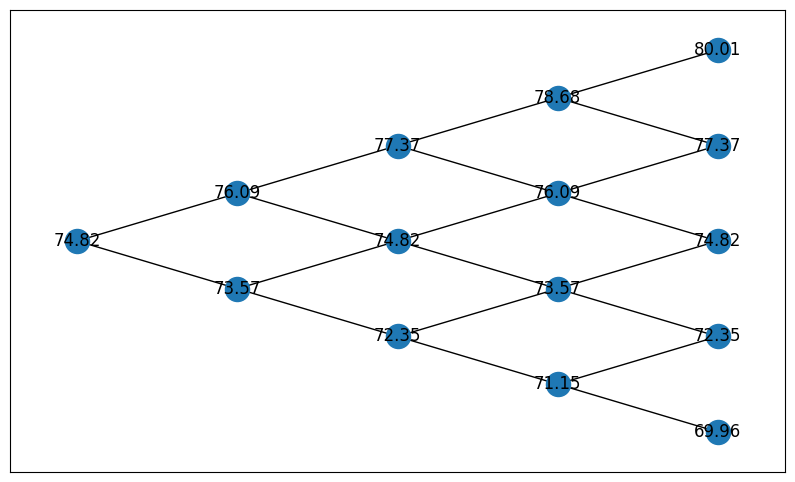

In [48]:
plt.figure(figsize=(10, 6))
posG = {}
labels = {}
i = 0
for node in G.nodes():
    posG[node] = (node[0], N + 2 + node[0] - 2 * node[1])
    i, j = node
    labels[node] = round(S[i][j - 1], 2)
nx.draw_networkx_nodes(G, posG)
nx.draw_networkx_edges(G, posG)
_ = nx.draw_networkx_labels(G, posG, labels)

In [49]:
option_call.get_prob()  # риск-нейтральные вероятности

(0.49836132431098107, 0.501638675689019)

In [50]:
option_call.get_param()  # параметры u и d

(1.0169225324714737, 0.9833590741368017)

In [51]:
option_put = CRR(S_0, K, r, T, N, sigma, is_call=False, div=div_y, is_european=True)

In [52]:
option_put.get_price()

2.0873942450000493

### Паритет пут-колл

In [53]:
K * np.exp(-r * (T - 0)) + option_call.get_price()

76.84954050055036

In [54]:
np.exp(-div_y * (T - 0)) * S_0 + option_put.get_price()

76.85079158508783

## 5. Модель BSM (Black Scholes Merton)

###  Модель Блэка-Шоулза и соответствующие формулы приведены в лекционных материалах. Программная реализация модели осуществляется с помощью создания класса. 

In [55]:
class BSM:
    def __init__(self, S_0, K, r, T, sigma, div=0, t=0, is_call=True):
        self._S_0 = S_0
        self._K = K
        self._r = r
        self._div = div
        self._T = T
        self._sigma = sigma
        self._t = t
        self._is_call = is_call

    def __d_values__(self):
        self._d1 = (
            np.log(self._S_0 / self._K)
            + (self._r - self._div + 0.5 * self._sigma**2) * (self._T - self._t)
        ) / (self._sigma * np.sqrt(self._T - self._t))
        self._d2 = self._d1 - self._sigma * np.sqrt(self._T - self._t)

    def __N_d__(self, d_value):
        return stats.norm.cdf(d_value)

    def __price__(self):
        return (
            (
                np.exp(-self._div * (self._T - self._t))
                * self._S_0
                * self.__N_d__(self._d1)
                - np.exp(-self._r * (self._T - self._t))
                * self._K
                * self.__N_d__(self._d2)
            )
            if self._is_call
            else (
                np.exp(-self._r * (self._T - self._t))
                * self._K
                * self.__N_d__(-self._d2)
                - np.exp(-self._div * (self._T - self._t))
                * self._S_0
                * self.__N_d__(-self._d1)
            )
        )

    def get_price(self):
        self.__d_values__()
        price = self.__price__()
        return price

    def get_delta(self):
        self.__d_values__()
        return self.__N_d__(self._d1) if self._is_call else self.__N_d__(self._d1) - 1

    def get_vega(self):
        self.__d_values__()
        return (
            self._S_0
            * stats.norm.pdf(self._d1)
            * np.sqrt(self._T - self._t)
            * np.exp(-self._div * (self._T - self._t))
        ) / 100

### Реализация модели BSM 

In [56]:
K = 76.5
r = 0.024
sigma = 0.2  # годовое значение
call = True

In [57]:
option_call = BSM(S_0, K, r, T, sigma, div=div_y, is_call=True)

In [58]:
option_call.get_price()

0.6057340061092162

In [59]:
option_call.get_delta()  # дельта опциона

0.3081168963970454

In [60]:
option_call.get_vega()  # вега опциона

0.055179630738617286

In [61]:
option_put = BSM(S_0, K, r, T, sigma, div=div_y, is_call=False)

In [62]:
option_put.get_price()

2.2615953049632083

In [63]:
option_put.get_delta()

-0.6918831036029546

In [64]:
option_put.get_vega()

0.055179630738617286

### Паритет пут-колл

In [65]:
K * np.exp(-r * (T - 0)) + option_call.get_price()

77.02499264505099

In [66]:
np.exp(-div_y * (T - 0)) * S_0 + option_put.get_price()

77.02499264505099

## 5. Опиционные стратегии

###  Bull spread

In [67]:
bull_spread_setup = pd.DataFrame(
    zip(
        ["Call", "Call"],
        [73, 76.5],
        [
            CRR(
                S_0, 73, r, T, N, sigma, is_call=True, div=div_y, is_european=False
            ).get_price(),
            CRR(
                S_0, 76.5, r, T, N, sigma, is_call=True, div=div_y, is_european=False
            ).get_price(),
        ],
        ["Buy", "Sell"],
    ),
    columns=["Type", "Strike", "Price", "Buy/Sell"],
)

In [68]:
bull_spread_setup

,Type,Strike,Price,Buy/Sell
0,Call,73.0,2.429435,Buy
1,Call,76.5,0.671883,Sell


In [69]:
bull_spread_result = pd.DataFrame(
    zip(
        range(70, 81),
        np.maximum(range(70, 81) - bull_spread_setup.iloc[0, 1], 0)
        - bull_spread_setup.iloc[0, 2],
        -np.maximum((range(70, 81) - bull_spread_setup.iloc[1, 1]), 0)
        + bull_spread_setup.iloc[1, 2],
    ),
    columns=["Spot", "Call1", "Call2"],
)

In [70]:
bull_spread_result["Result"] = bull_spread_result["Call1"] + bull_spread_result["Call2"]

In [71]:
bull_spread_result

,Spot,Call1,Call2,Result
0,70,-2.429435,0.671883,-1.757552
1,71,-2.429435,0.671883,-1.757552
2,72,-2.429435,0.671883,-1.757552
3,73,-2.429435,0.671883,-1.757552
4,74,-1.429435,0.671883,-0.757552
5,75,-0.429435,0.671883,0.242448
6,76,0.570565,0.671883,1.242448
7,77,1.570565,0.171883,1.742448
8,78,2.570565,-0.828117,1.742448
9,79,3.570565,-1.828117,1.742448


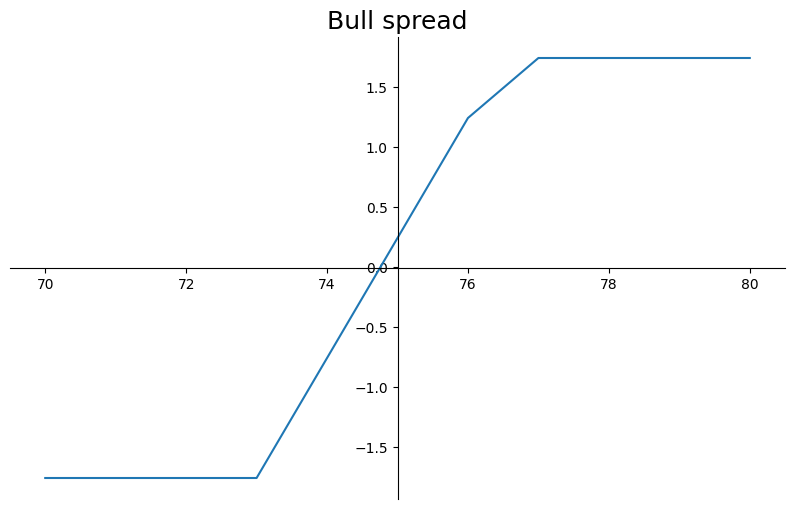

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(bull_spread_result.Spot, bull_spread_result.Result)
ax = plt.gca()
ax.spines["left"].set_position("center")
ax.spines["right"].set_color("none")
ax.spines["bottom"].set_position("center")
ax.spines["top"].set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_ticks_position("left")
_ = plt.title("Bull spread", fontsize=18)

###  Long straddle

In [73]:
long_straddle_setup = pd.DataFrame(
    zip(
        ["Call", "Put"],
        [75, 75],
        [
            CRR(
                S_0, 75, r, T, N, sigma, is_call=True, div=div_y, is_european=False
            ).get_price(),
            CRR(
                S_0, 75, r, T, N, sigma, is_call=False, div=div_y, is_european=False
            ).get_price(),
        ],
        ["Buy", "Buy"],
    ),
    columns=["Type", "Strike", "Price", "Buy/Sell"],
)

In [74]:
long_straddle_setup

,Type,Strike,Price,Buy/Sell
0,Call,75,1.132735,Buy
1,Put,75,1.294554,Buy


In [75]:
long_straddle_result = pd.DataFrame(
    zip(
        range(70, 81),
        np.maximum(range(70, 81) - long_straddle_setup.iloc[0, 1], 0)
        - long_straddle_setup.iloc[0, 2],
        np.maximum(long_straddle_setup.iloc[1, 1] - (range(70, 81)), 0)
        - long_straddle_setup.iloc[1, 2],
    ),
    columns=["Spot", "Call", "Put"],
)

In [76]:
long_straddle_result["Result"] = (
    long_straddle_result["Call"] + long_straddle_result["Put"]
)

In [77]:
long_straddle_result

,Spot,Call,Put,Result
0,70,-1.132735,3.705446,2.572712
1,71,-1.132735,2.705446,1.572712
2,72,-1.132735,1.705446,0.572712
3,73,-1.132735,0.705446,-0.427288
4,74,-1.132735,-0.294554,-1.427288
5,75,-1.132735,-1.294554,-2.427288
6,76,-0.132735,-1.294554,-1.427288
7,77,0.867265,-1.294554,-0.427288
8,78,1.867265,-1.294554,0.572712
9,79,2.867265,-1.294554,1.572712


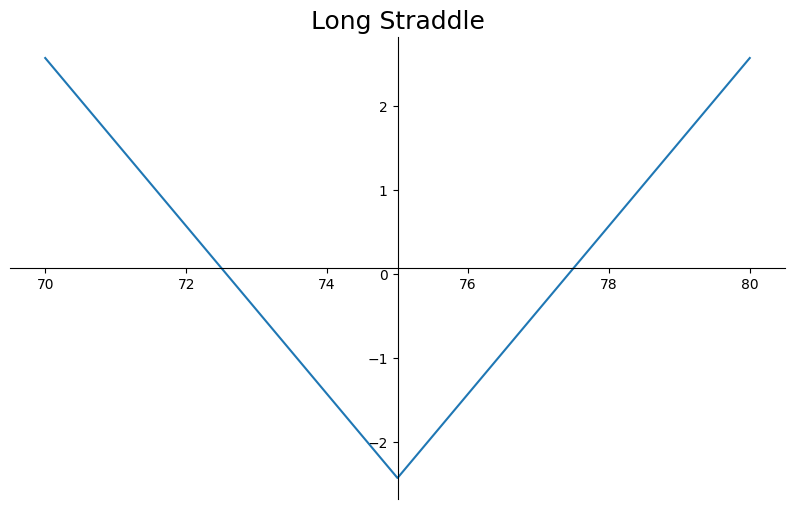

In [78]:
fig = plt.figure(figsize=(10, 6))
plt.plot(long_straddle_result.Spot, long_straddle_result.Result)
ax = plt.gca()
ax.spines["left"].set_position("center")
ax.spines["right"].set_color("none")
ax.spines["bottom"].set_position("center")
ax.spines["top"].set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")
_ = plt.title("Long Straddle", fontsize=18)

## 6. Сравнение теоретических и рыночных цен

В данном разделе задания рассчитаем теоретические цены опционов с помощью моделей CRR и BSM  и сравним их с рыночными ценами

In [79]:
N = 1000  # количество шагов для модели CRR

### Call

In [80]:
cboe_XOM_call["American_div_Bin"] = cboe_XOM_call.apply(
    lambda row: np.round(
        CRR(
            S_0,
            row["strike"],
            r,
            T,
            N,
            row["implied_volatility_1545"],
            is_call=True,
            div=div_y,
            is_european=False,
        ).get_price(),
        4,
    ),
    axis=1,
)

In [81]:
cboe_XOM_call["European_div_Bin"] = cboe_XOM_call.apply(
    lambda row: np.round(
        CRR(
            S_0,
            row["strike"],
            r,
            T,
            N,
            row["implied_volatility_1545"],
            is_call=True,
            div=div_y,
            is_european=True,
        ).get_price(),
        4,
    ),
    axis=1,
)

In [82]:
cboe_XOM_call["BSM_div"] = cboe_XOM_call.apply(
    lambda row: np.round(
        BSM(
            S_0, row["strike"], r, T, row["implied_volatility_1545"], is_call=True
        ).get_price(),
        4,
    ),
    axis=1,
)

In [83]:
cboe_XOM_call

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545,American_div_Bin,European_div_Bin,BSM_div
2640,72.5,2.91,2.10,2.36,0.7241,0.1100,0.0426,0.2294,2.8825,2.8825,2.9229
2642,73.0,2.15,1.80,1.80,0.6797,0.1305,0.0458,0.2076,2.4091,2.4091,2.4486
2644,73.5,1.71,1.28,1.44,0.6165,0.1484,0.0490,0.1955,2.0002,2.0002,2.0373
2646,74.0,1.58,0.97,1.10,0.5410,0.1630,0.0511,0.1856,1.6253,1.6253,1.6592
2648,74.5,1.53,0.68,0.81,0.4557,0.1724,0.0512,0.1756,1.2765,1.2765,1.3073
2650,75.0,1.27,0.48,0.58,0.3664,0.1698,0.0487,0.1696,0.9859,0.9859,1.0129
2652,75.5,0.71,0.32,0.36,0.2807,0.1562,0.0436,0.1653,0.7436,0.7436,0.7664
2654,76.0,0.65,0.22,0.24,0.2054,0.1340,0.0369,0.1628,0.5506,0.5506,0.5692
2656,76.5,0.60,0.15,0.15,0.1453,0.1079,0.0296,0.1623,0.4046,0.4046,0.4194
2658,77.0,0.17,0.10,0.10,0.0992,0.0824,0.0226,0.1624,0.2925,0.2925,0.3041


### Put

In [84]:
cboe_XOM_put["American_div_Bin"] = cboe_XOM_put.apply(
    lambda row: np.round(
        CRR(
            S_0,
            row["strike"],
            r,
            T,
            N,
            row["implied_volatility_1545"],
            is_call=False,
            div=div_y,
            is_european=False,
        ).get_price(),
        4,
    ),
    axis=1,
)

In [85]:
cboe_XOM_put["European_div_Bin"] = cboe_XOM_put.apply(
    lambda row: np.round(
        CRR(
            S_0,
            row["strike"],
            r,
            T,
            N,
            row["implied_volatility_1545"],
            is_call=False,
            div=div_y,
            is_european=True,
        ).get_price(),
        4,
    ),
    axis=1,
)

In [86]:
cboe_XOM_put["BSM_div"] = cboe_XOM_put.apply(
    lambda row: np.round(
        BSM(
            S_0, row["strike"], r, T, row["implied_volatility_1545"], is_call=False
        ).get_price(),
        4,
    ),
    axis=1,
)

In [87]:
cboe_XOM_put

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545,American_div_Bin,European_div_Bin,BSM_div
2641,72.5,0.56,0.27,0.40,-0.2478,0.1171,0.0410,0.2069,0.4323,0.4320,0.4189
2643,73.0,0.66,0.53,0.53,-0.3088,0.1327,0.0456,0.2033,0.5453,0.5449,0.5293
2645,73.5,0.91,0.72,0.72,-0.3785,0.1445,0.0492,0.2013,0.6917,0.6912,0.6722
2647,74.0,1.15,0.88,0.90,-0.4532,0.1512,0.0511,0.2001,0.8703,0.8697,0.8474
2649,74.5,1.39,1.16,1.19,-0.5295,0.1508,0.0513,0.2012,1.0942,1.0933,1.0670
2651,75.0,1.75,1.36,1.45,-0.6029,0.1446,0.0496,0.2027,1.3518,1.3506,1.3210
2653,75.5,2.11,1.49,1.90,-0.6685,0.1325,0.0465,0.2075,1.6614,1.6600,1.6264
2655,76.0,2.40,2.18,2.29,-0.7258,0.1184,0.0425,0.2124,1.9995,1.9977,1.9606
2657,76.5,0.00,0.00,0.00,-0.7664,0.1021,0.0389,0.2254,2.4081,2.4060,2.3662
2659,77.0,3.30,2.80,3.30,-0.7958,0.0878,0.0359,0.2416,2.8500,2.8476,2.8061


## 7. Показатель чувствительности $\Delta$

Delta - hedging. Расчет показателя $\Delta$ приведен в лекционных материалах.

$C=\Delta S-B$
$P=\Delta S+B$

На каждом шаге мы ребалансируем портфель с учетом равенства:
$dP=\Delta dS$ (для опциона колл расчет аналогичный)
Ребалансировка учитывает проценты по денежной позиции

В данном задании будем моделировать динамику актива с помощью геометрического броуновского движения

$S_{i+1}=S_iexp((r-0.5\sigma^2)\Delta_t+\sigma\sqrt{\Delta_t}Z_t)$

In [88]:
def GBM(n_step, S_0, r, sigma, dt):
    S = np.zeros(n_step)
    S[0] = S_0
    rand = np.random.standard_normal(n_step)
    for i in range(1, n_step):
        S[i] = S[i - 1] * np.exp(
            (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rand[i]
        )
    return S

### Реализуем пошаговый процесс репликации опциона (создания портфеля, воспроизводящего стоимость опциона)

In [89]:
r = 0.0024
T = 20 / 250
sigma = 0.2  # годовое значение
n_step = int(T * 250)
dt = 1 / 250

In [90]:
S = np.zeros(n_step)  # массив цен акци
Delta = np.zeros(n_step)  # массив дельт
Option_theor = np.zeros(n_step)  # массив теоретических цен
S_Delta = np.zeros(n_step)  # произведение цен и дельт
Bond = np.zeros(n_step)  # денежная позиция
Replicate = np.zeros(n_step)  # репликация

### Расчет первоначальных значений параметров

In [91]:
S[0] = S_0

In [92]:
option = BSM(S_0, K, r, T, sigma, t=0, is_call=False)

In [93]:
Option_theor[0] = option.get_price()
Replicate[0] = Option_theor[0]
print(Option_theor[0])

2.667335460068408


In [94]:
Delta[0] = option.get_delta()
S_Delta[0] = S[0] * Delta[0]
print(Delta[0])

-0.6408992135521214


In [95]:
Bond[0] = Option_theor[0] - S_Delta[0]
print(Bond[0])

50.619414422451214


In [96]:
S = GBM(n_step, S_0, r, sigma, dt)  # моделирование динамики

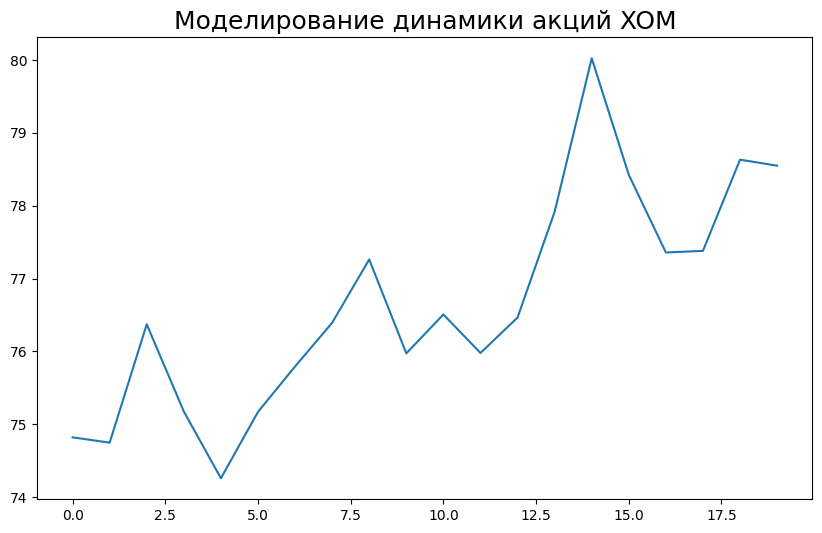

In [97]:
plt.figure(figsize=(10, 6))
_ = plt.plot(S)
_ = plt.title("Моделирование динамики акций XOM", fontsize=18)

### Пошаговая репликация

In [98]:
for i in range(1, n_step):
    option = BSM(S[i], K, r, T, sigma, is_call=False, t=i / 250)
    Option_theor[i] = option.get_price()
    Delta[i] = option.get_delta()
    S_Delta[i] = S[i] * Delta[i]
    Replicate[i] = (
        Replicate[i - 1]
        + (S[i] - S[i - 1]) * Delta[i - 1]
        + Bond[i - 1] * (np.exp(r / 250) - 1)
    )
    Bond[i] = Option_theor[i] - S_Delta[i]

In [99]:
pd.DataFrame(
    zip(S, Option_theor, Replicate, Delta, S_Delta, Bond),
    columns=["S", "Theor_price", "Replicate", "Delta", "Delta*Price", "Bond"],
).head()

,S,Theor_price,Replicate,Delta,Delta*Price,Bond
0,74.820000,2.667335,2.667335,-0.640899,-47.952079,50.619414
1,74.747181,2.675051,2.714491,-0.651556,-48.701940,51.376991
2,76.371700,1.694299,1.656520,-0.500489,-38.223167,39.917466
3,75.175074,2.319871,2.255801,-0.620116,-46.617273,48.937144
4,74.257991,2.889310,2.824968,-0.712110,-52.879873,55.769182


## 8. Показатель чувствительности Vega

Расчет показателя vega приведен в лекционных материалах

In [100]:
strikes_range

array([72.5, 73. , 73.5, 74. , 74.5, 75. , 75.5, 76. , 76.5, 77. ])

In [101]:
prices_market = np.array(cboe_XOM_call.close)

In [102]:
prices_market

array([2.36, 1.8 , 1.44, 1.1 , 0.81, 0.58, 0.36, 0.24, 0.15, 0.1 ])

Нахождение оптимального значения IV методом Ньютона-Рафсона

$\sigma_{i+1}=\sigma_{i}-\frac{c(\sigma_{i})-c_m}{Vega}$

Для корректной реализации алгоритма необходимо, чтобы рыночная стоимость была не меньше внутренней стоимости

In [103]:
# Newton-Raphson
T = days / 250
sigma_list = []
tol = 0.001
for strike, price in zip(strikes_range, prices_market):
    if (strike + price) > S_0:
        sigma = 0.3
        diff = 1000
        while diff > tol:
            option = BSM(S_0, strike, r, T, sigma, div=div_y)
            Price_theor = option.get_price()
            Vega = option.get_vega() * 100
            #      print(Price_theor)
            sigma_prev = sigma
            sigma = sigma_prev - (Price_theor - price) / Vega
            diff = abs(price - Price_theor)
        sigma_list.append((strike, sigma))

### Массив значений IV для каждого страйка

In [104]:
sigma_list

[(72.5, 0.11659323715754646),
 (73.5, 0.09719123276052852),
 (74.0, 0.10315878270686203),
 (74.5, 0.10658085468102577),
 (75.0, 0.10985030466193309),
 (75.5, 0.10521414162790386),
 (76.0, 0.10881591660902135),
 (76.5, 0.11051648962903318),
 (77.0, 0.1153224265243674)]

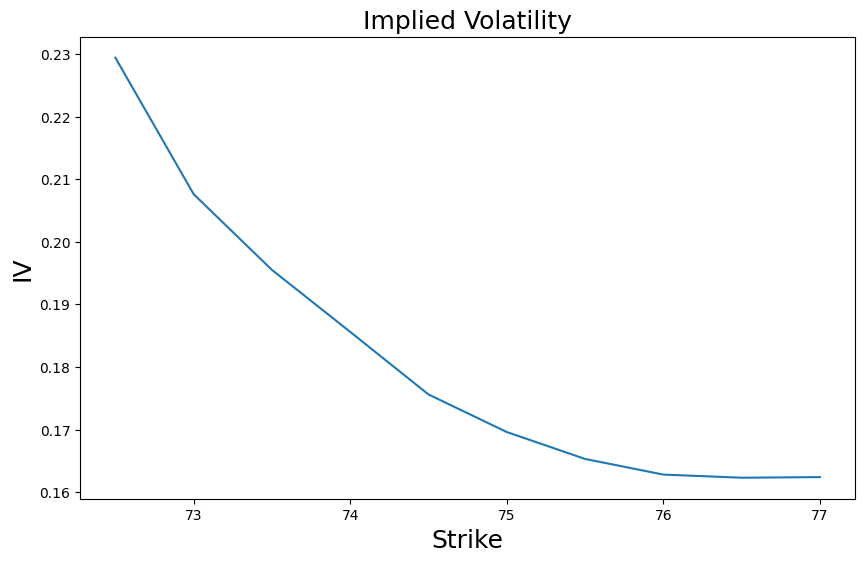

In [105]:
plt.figure(figsize=(10, 6))
_ = plt.plot(cboe_XOM_call.strike, cboe_XOM_call.implied_volatility_1545)
_ = plt.xlabel("Strike", fontsize=18)
_ = plt.ylabel("IV", fontsize=18)
_ = plt.title("Implied Volatility", fontsize=18)

# Выводы:

1. Для анализа рынка опционов была выбрана компания *Exxon Mobil Corporation (**XOM**)*. Для этой компании была выбрана одна дата экспирации и сформирована цепочка страйков.
2. Были рассчитаны теоретические стоимости опционов с помощью моделей CRR и BSM. 
3. Рассчитаны параметры для опционных стратегий *Bull spread* и *Long straddle*, по результатам построены графики.
4. Проведено моделирование динамики акций *Exxon Mobil*.
5. Рассчитан показатель чувствительности $\Delta$, при помощи которого проведена процедура дельта-хеджирования.
6. Найден показатель *Implied Volatility* для каждого графика и построен график зависимости показателя IV от страйка.
